# Example: TabNet does not learn interesting features

Dataset: Census-Income 
Experiments:
* 1: We provide interesting features for the model. 
* 2: We provide a lot of features for the model to choose.

In [1]:
from pytorch_tabnet.tab_model import TabNetRegressor

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import pandas as pd
import numpy as np
np.random.seed(0)


import os
import wget
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
def predict(model, x, y, dataset_name):
    y_pred = model.predict(x).reshape(-1)
    y_true = y.reshape(-1)
    score = mean_squared_error(y_pred=y_pred, y_true=y_true)
#     print(f"BEST VALID SCORE FOR {dataset_name} : {model.best_cost}")
    print(f"SCORE FOR {dataset_name} : {score}")
    return y_true, y_pred


def plot_results(y_true, y_pred):
    plt.figure(figsize=(15, 8))
    df_result = pd.DataFrame({'y_true': y_true,
                             'y_pred': y_pred}).reset_index().rename(columns={'index': 'date'})
    df_result_melted = pd.melt(df_result, id_vars=['date'], value_vars=['y_true', 'y_pred'])
    ax = sns.lineplot(x='date', y='value', hue='variable', data=df_result_melted)

In [18]:
def _generate_autoregressive_feature(X_y, step=1):
    X_y[f'passengers_-{step}'] = X_y['passengers'].shift(step) 
    # fillna strategy
    X_y.loc[X_y[f'passengers_-{step}'].isna(), f'passengers_-{step}'] = X_y.loc[X_y[f'passengers_-{step}'].isna(), 'passengers']
    return X_y

---
# Common Phases
### Download census-income dataset

In [10]:
url = 'https://raw.githubusercontent.com/BhavyaGulati/TimeSeries-FlightPassesngerPrediction/master/international-airline-passengers.csv'

In [11]:
# url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
dataset_name = 'international-airline-passengers'
out = Path(os.getcwd()+'/data/'+dataset_name+'.csv')

In [12]:
out.parent.mkdir(parents=True, exist_ok=True)
if out.exists():
    print("File already exists.")
else:
    print("Downloading file...")
    wget.download(url, out.as_posix())

File already exists.


---
### Load data

In [13]:
data = pd.read_csv(out, header=None).rename(columns={0: 'date', 1: 'passengers'})
# clean
data = data.loc[~(data['date']== 'International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60')]
data['date'] = pd.to_datetime(data['date'], format='%Y-%m')
data.sort_values('date', inplace=True)
data.head()

,date,passengers
0,1949-01-01,112.0
1,1949-02-01,118.0
2,1949-03-01,132.0
3,1949-04-01,129.0
4,1949-05-01,121.0


In [14]:
display(data.shape)
display(data.shape[0] / 12)

(144, 2)

12.0

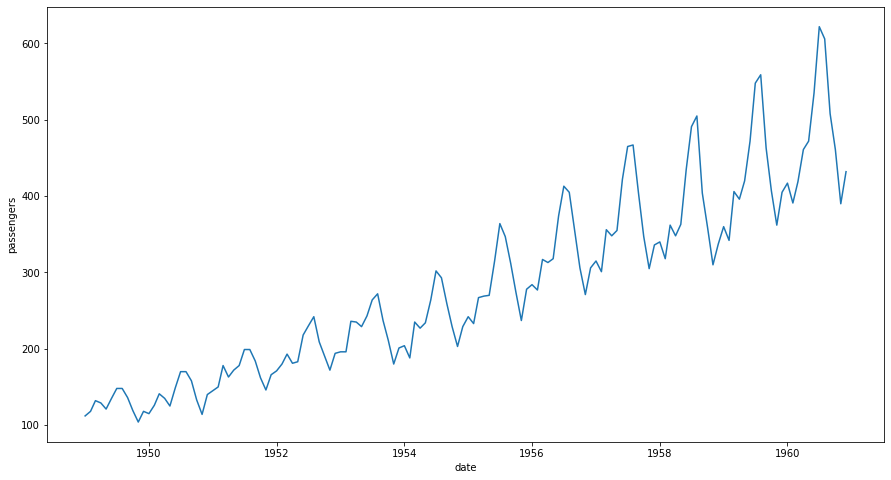

In [15]:
plt.figure(figsize=(15, 8))
ax = sns.lineplot(x='date', y='passengers', data=data)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

We can see that the timeseries have clearly two components: 
* Seasonality
* Trend

### Train-Validation-Test Split

In [16]:
validation_fraction, test_fraction = (0.2, 0.2)
train_fraction = 1 - validation_fraction - test_fraction

Because we are dealing with timeseries data, we will train on the first segment of data, validate with the second one, and test with the most recent chunk.

In [17]:
n_train = int(round(len(data) * train_fraction))
print(f'Using {n_train} points to train')

n_val = int(round(len(data) * validation_fraction))
print(f'Using {n_val} points to validate')

n_test = len(data) - n_train - n_val
print(f'Using {n_test} points to test')

Using 86 points to train
Using 29 points to validate
Using 29 points to test


---
---
---
# Experiment 1: Interesting features are provided

### Feature Generation

Given the properties seen on the timeseries we create features to try to capture those patterns:
* Seasonality: passengers_-1
* Trend: passengers_-12

In [21]:
X_y = data.copy()
FEATURES_TO_USE = []
for step in [1, 12]:
    X_y = _generate_autoregressive_feature(X_y, step=step)
    FEATURES_TO_USE.append(f'passengers_-{step}')
X_y.tail(13)

,date,passengers,passengers_-1,passengers_-12
131,1959-12-01,405.0,362.0,337.0
132,1960-01-01,417.0,405.0,360.0
133,1960-02-01,391.0,417.0,342.0
134,1960-03-01,419.0,391.0,406.0
135,1960-04-01,461.0,419.0,396.0
136,1960-05-01,472.0,461.0,420.0
137,1960-06-01,535.0,472.0,472.0
138,1960-07-01,622.0,535.0,548.0
139,1960-08-01,606.0,622.0,559.0
140,1960-09-01,508.0,606.0,463.0


In [23]:
X = X_y[FEATURES_TO_USE].values
y = X_y[['passengers']].values

In [24]:
X_train, y_train = X[:n_train], y[:n_train]
X_val, y_val = X[n_train:n_train+n_val], y[n_train:n_train+n_val]
X_test, y_test = X[n_train+n_val:], y[n_train + n_val:]

## Create Model

In [27]:
tabnet_regressor = TabNetRegressor()

Device used : cuda


### Training

In [25]:
max_epochs = 1000

In [30]:
tabnet_regressor.fit(
    X_train=X_train, y_train=y_train,
    X_valid=X_val, y_valid=y_val,
    max_epochs=max_epochs,
    patience=100,
    batch_size=1024, 
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
) 

Will train until validation stopping metric hasn't improved in 100 rounds.
---------------------------------------
| EPOCH |  train  |   valid  | total time (s)
| 1     | -44154.26172 |  -1209990.25000 |   0.0       
| 2     | -43831.19922 |  -483902.56250 |   0.1       
| 3     | -43610.92188 |  -306801.34375 |   0.1       
| 4     | -43401.77734 |  -180946.62500 |   0.2       
| 5     | -43297.95312 |  -170274.82812 |   0.2       
| 6     | -43225.37500 |  -196815.37500 |   0.3       
| 7     | -43165.75391 |  -184462.76562 |   0.3       
| 8     | -43109.44141 |  -165703.53125 |   0.3       
| 9     | -43052.87500 |  -149560.20312 |   0.4       
| 10    | -43002.05859 |  -139751.85938 |   0.4       
| 11    | -42955.16797 |  -134458.75000 |   0.5       
| 12    | -42909.06250 |  -130258.60938 |   0.5       
| 13    | -42853.80078 |  -125691.34375 |   0.5       
| 14    | -42810.46484 |  -121743.53125 |   0.6       
| 15    | -42760.62109 |  -118923.08594 |   0.6       
| 16    | -42

SCORE FOR TRAIN : 1500.5971062187818


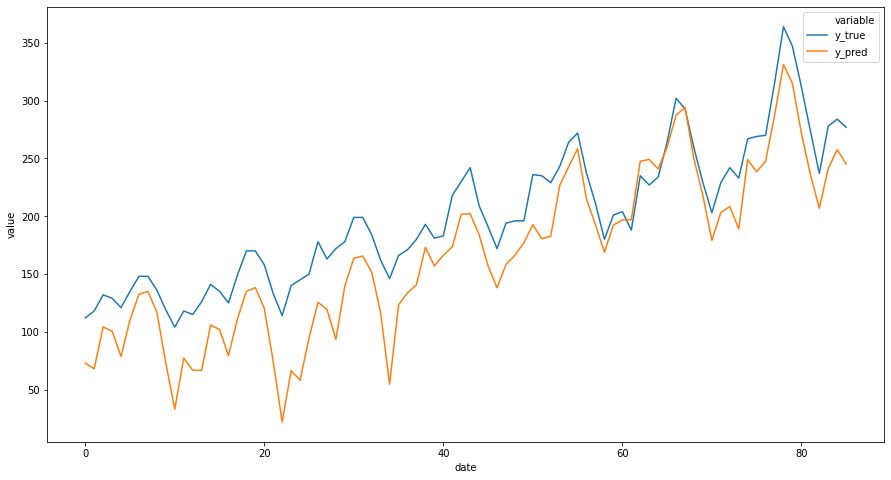

In [31]:
y_true, y_pred = predict(model=tabnet_regressor, x=X_train, y=y_train, dataset_name='TRAIN');
plot_results(y_true, y_pred)

SCORE FOR VALIDATION : 502.85204270569574


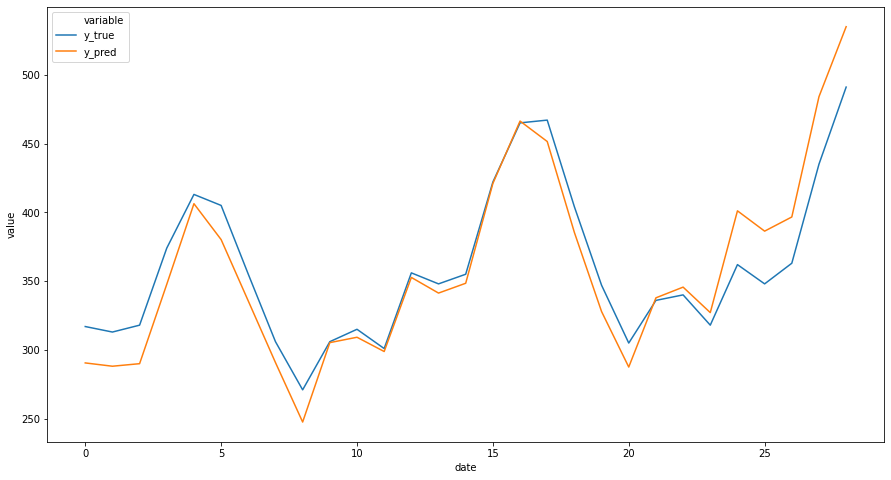

In [32]:
y_true, y_pred = predict(model=tabnet_regressor, x=X_val, y=y_val, dataset_name='VALIDATION');
plot_results(y_true, y_pred)

SCORE FOR TEST : 563.0241579174802


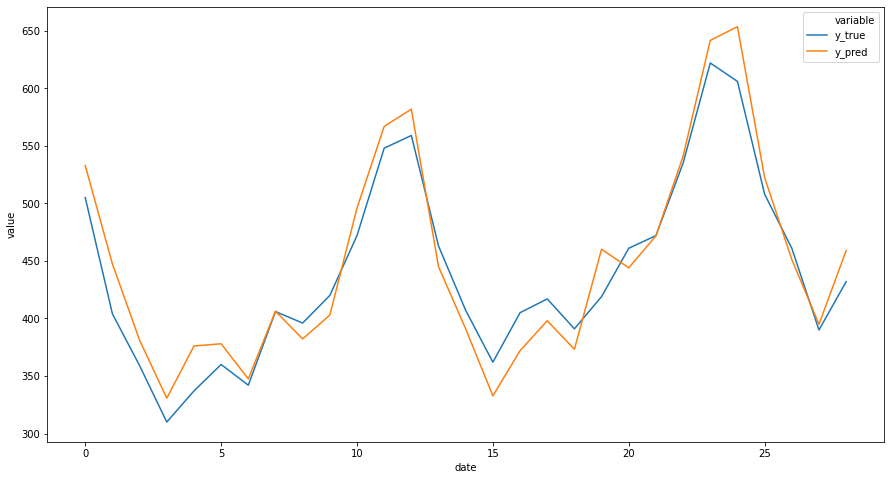

In [33]:
y_true, y_pred = predict(model=tabnet_regressor, x=X_test, y=y_test, dataset_name='TEST');
plot_results(y_true, y_pred)

### Global explainability : feat importance summing to 1

In [34]:
tabnet_regressor.feature_importances_

array([0.3848719, 0.6151281])

---
---
---
# Experiment 2: All Autoregressive features are provided

### Feature Generation

We pass on the features in the previous months

In [35]:
X_y = data.copy()
FEATURES_TO_USE = []
for step in range(1, 13):
    X_y = _generate_autoregressive_feature(X_y, step=step)
    FEATURES_TO_USE.append(f'passengers_-{step}')
X_y.tail(13)

,date,passengers,passengers_-1,passengers_-2,passengers_-3,passengers_-4,passengers_-5,passengers_-6,passengers_-7,passengers_-8,passengers_-9,passengers_-10,passengers_-11,passengers_-12
131,1959-12-01,405.0,362.0,407.0,463.0,559.0,548.0,472.0,420.0,396.0,406.0,342.0,360.0,337.0
132,1960-01-01,417.0,405.0,362.0,407.0,463.0,559.0,548.0,472.0,420.0,396.0,406.0,342.0,360.0
133,1960-02-01,391.0,417.0,405.0,362.0,407.0,463.0,559.0,548.0,472.0,420.0,396.0,406.0,342.0
134,1960-03-01,419.0,391.0,417.0,405.0,362.0,407.0,463.0,559.0,548.0,472.0,420.0,396.0,406.0
135,1960-04-01,461.0,419.0,391.0,417.0,405.0,362.0,407.0,463.0,559.0,548.0,472.0,420.0,396.0
136,1960-05-01,472.0,461.0,419.0,391.0,417.0,405.0,362.0,407.0,463.0,559.0,548.0,472.0,420.0
137,1960-06-01,535.0,472.0,461.0,419.0,391.0,417.0,405.0,362.0,407.0,463.0,559.0,548.0,472.0
138,1960-07-01,622.0,535.0,472.0,461.0,419.0,391.0,417.0,405.0,362.0,407.0,463.0,559.0,548.0
139,1960-08-01,606.0,622.0,535.0,472.0,461.0,419.0,391.0,417.0,405.0,362.0,407.0,463.0,559.0
140,1960-09-01,508.0,606.0,622.0,535.0,472.0,461.0,419.0,391.0,417.0,405.0,362.0,407.0,463.0


In [36]:
X = X_y[FEATURES_TO_USE].values
y = X_y[['passengers']].values

In [37]:
X_train, y_train = X[:n_train], y[:n_train]
X_val, y_val = X[n_train:n_train+n_val], y[n_train:n_train+n_val]
X_test, y_test = X[n_train+n_val:], y[n_train + n_val:]

## Create Model

In [39]:
tabnet_regressor = TabNetRegressor()

Device used : cuda


### Training

In [40]:
max_epochs = 1000

In [41]:
tabnet_regressor.fit(
    X_train=X_train, y_train=y_train,
    X_valid=X_val, y_valid=y_val,
    max_epochs=max_epochs,
    patience=100,
    batch_size=1024, 
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
) 

Will train until validation stopping metric hasn't improved in 100 rounds.
---------------------------------------
| EPOCH |  train  |   valid  | total time (s)
| 1     | -43299.53516 |  -208599.26562 |   0.0       
| 2     | -43129.93750 |  -140763.35938 |   0.1       
| 3     | -42775.24609 |  -71415.59375 |   0.1       
| 4     | -42554.10156 |  -55690.41406 |   0.2       
| 5     | -42300.41016 |  -42232.28906 |   0.2       
| 6     | -42113.36328 |  -42442.02734 |   0.3       
| 7     | -41925.14062 |  -35053.64062 |   0.3       
| 8     | -41711.73438 |  -33205.78125 |   0.3       
| 9     | -41552.71484 |  -38209.48828 |   0.4       
| 10    | -41371.12500 |  -40855.51172 |   0.4       
| 11    | -41161.45312 |  -31503.08594 |   0.5       
| 12    | -41028.82422 |  -32398.54297 |   0.5       
| 13    | -40827.54297 |  -28331.06445 |   0.5       
| 14    | -40632.41016 |  -19975.83008 |   0.6       
| 15    | -40413.14062 |  -13842.86816 |   0.6       
| 16    | -40197.96094 |  -

SCORE FOR TRAIN : 1149.1233867287283


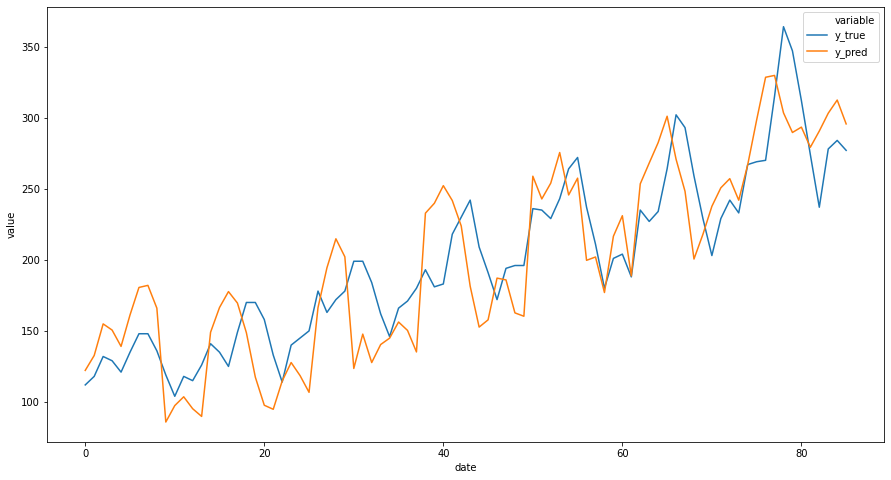

In [42]:
y_true, y_pred = predict(model=tabnet_regressor, x=X_train, y=y_train, dataset_name='TRAIN');
plot_results(y_true, y_pred)

SCORE FOR VALIDATION : 4599.493452264574


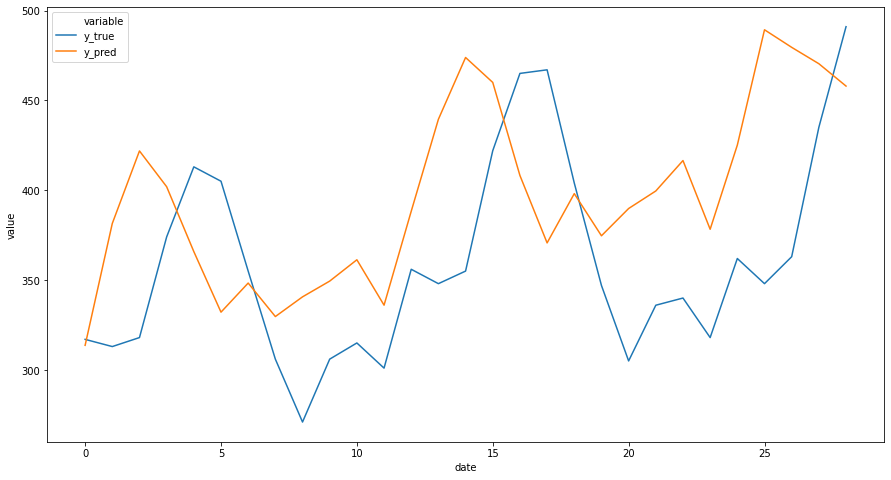

In [43]:
y_true, y_pred = predict(model=tabnet_regressor, x=X_val, y=y_val, dataset_name='VALIDATION');
plot_results(y_true, y_pred)

SCORE FOR TEST : 13168.386048964707


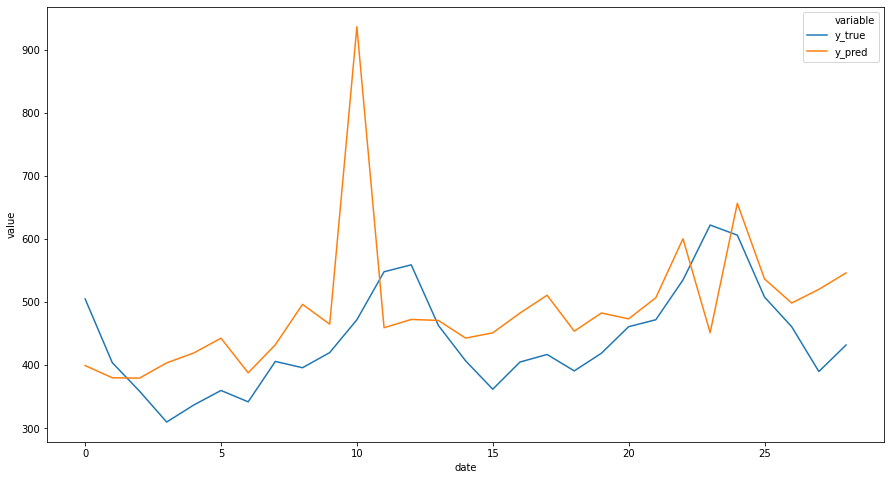

In [44]:
y_true, y_pred = predict(model=tabnet_regressor, x=X_test, y=y_test, dataset_name='TEST');
plot_results(y_true, y_pred)

### Global explainability : feat importance summing to 1

In [45]:
tabnet_regressor.feature_importances_

array([0.08086063, 0.01829566, 0.10005057, 0.0098951 , 0.29768747,
       0.        , 0.01246277, 0.0612676 , 0.00272837, 0.41675182,
       0.        , 0.        ])